# Data imports and filters


### Metal count

                 count
time                  
2024-02-29  13397882.0
2024-03-01  13399650.0
2024-03-02  13410996.0
2024-03-03  13421758.0
2024-03-04  13468463.0


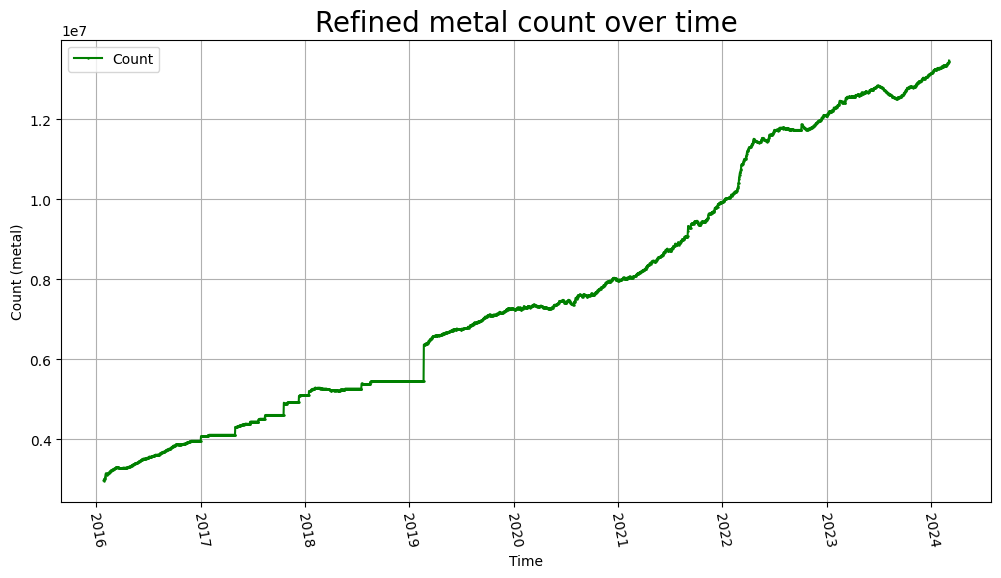

In [2]:
import matplotlib.pyplot as plt
import csv
import datetime
import pandas as pd

timestamps = []
count = []

with open('counthistorybetter.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        if int(row[0]) >= 1654992000:
            timestamps.append(int(row[0]))
            count.append(int(row[1]) + 1780000)
        elif int(row[0]) <= 1453795200:
            pass
        else:
            timestamps.append(int(row[0]))
            count.append(int(row[1]))
datescount = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

# making into dataframe
df_count = pd.DataFrame({'time': datescount, 'count': count})
df_count.set_index('time', inplace=True)
df_count_resampled = df_count.resample('D').mean().interpolate(method='linear')
print(df_count_resampled.tail())
# plotting
plt.figure(figsize=(12, 6))
plt.plot(df_count_resampled.index, df_count_resampled['count'], color = 'g', linestyle = 'solid',
         marker = '.', markersize=1.5, label = "Count")

plt.xticks(rotation = 1000000)
plt.xlabel('Time')
plt.ylabel('Count (metal)')
plt.title('Refined metal count over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

### Metal prices


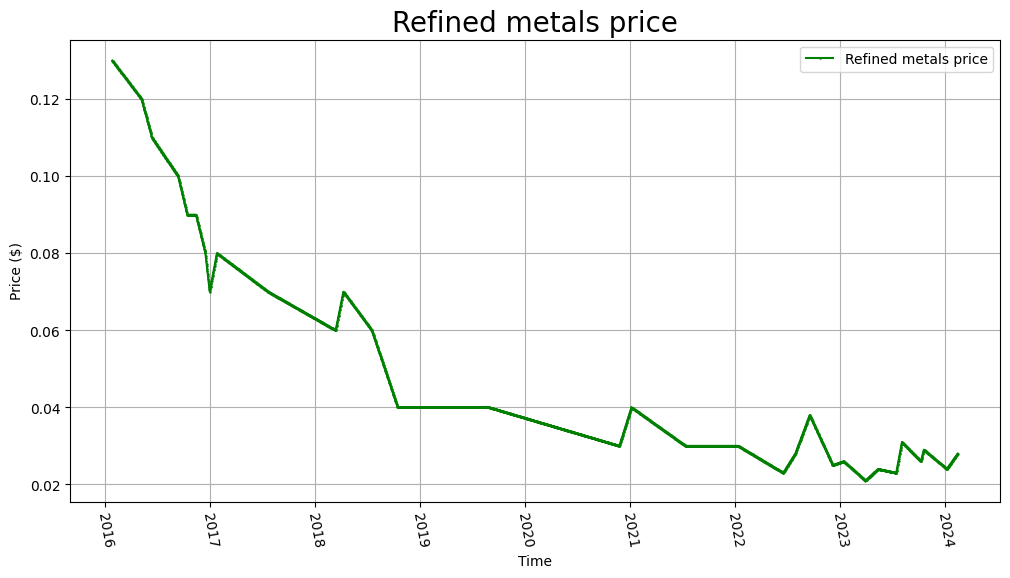

In [3]:
timestampsprice = []
prices = []

with open('priceshistorynew.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        if int(row[0].strip()) >= 1453795200:
            timestampsprice.append(int(row[0].strip()))
            prices.append(float(row[1]))

datesprice = [datetime.datetime.fromtimestamp(ts) for ts in timestampsprice]

# making into dataframe
df_price = pd.DataFrame({'time': datesprice, 'price': prices})
df_price[['flag']] = 1
df_price.set_index('time', inplace=True)

# resampling and interpolating
df_price_resampled = df_price.resample('D').mean().interpolate(method='linear')

# plotting
plt.figure(figsize=(12, 6))
plt.plot(df_price_resampled.index, df_price_resampled['price'], color = 'g', linestyle = 'solid',
         marker = '.', markersize=1.5, label = "Refined metals price")
plt.xticks(rotation = 1000000)
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.title('Refined metals price', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

In [4]:
# df_price_resampled[df_price_resampled.index.isin(df_price.index.date)]

In [5]:
# any(df_price_resampled.index.isin(df_price.index.date))

# Autocorrelation

### Metal Count

                count
time                 
2016-01-27  2971235.0
2016-01-28  2987157.0
2016-01-29  3004668.0
2016-01-30  3008474.0
2016-01-31  3016721.0


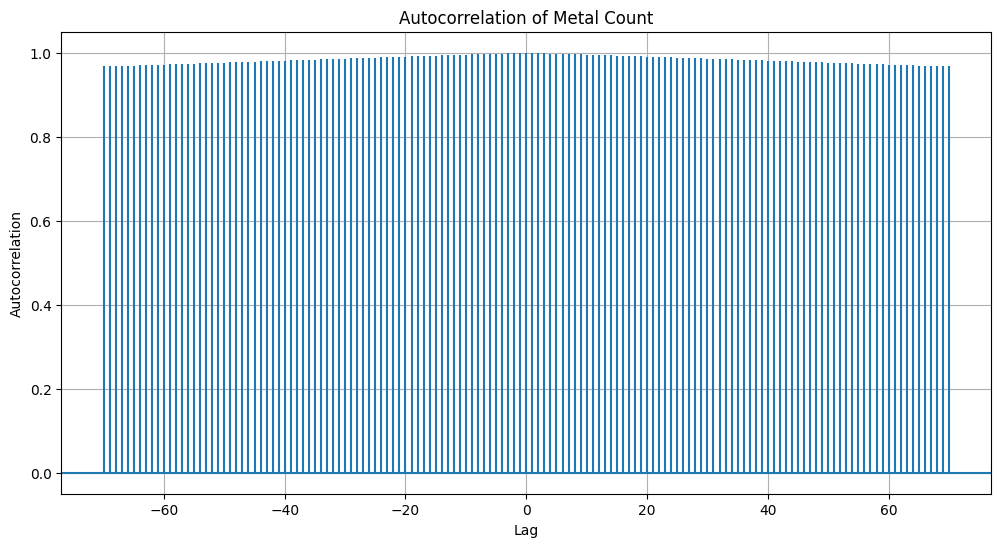

In [6]:
print(df_count_resampled.head())
autocorr_resampled_interpolated = df_count_resampled['count'].autocorr()

plt.figure(figsize=(12, 6))
plt.acorr(df_count_resampled['count'], maxlags=70)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Metal Count')
plt.grid(True)
plt.show()

### Metal Price 

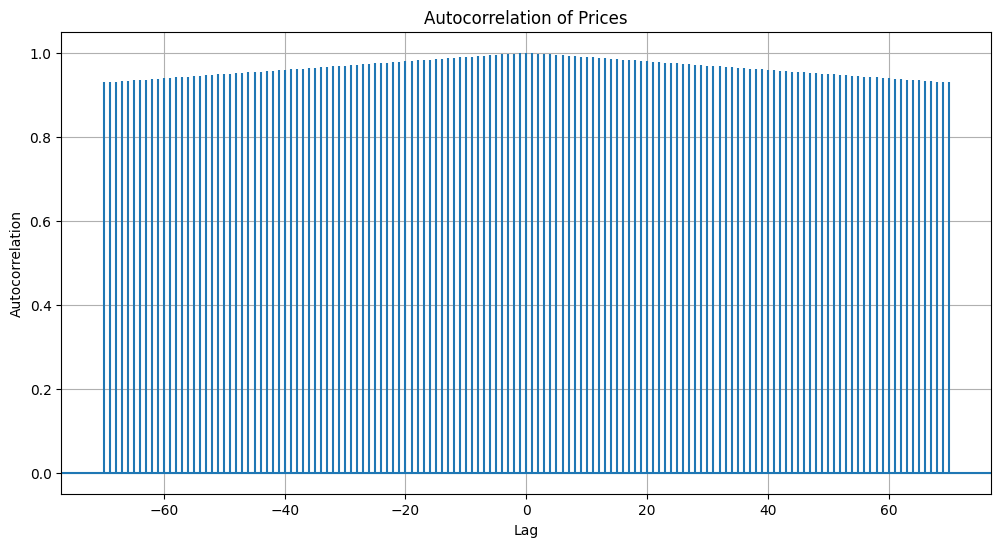

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

autocorr_resampled_interpolated = df_price_resampled['price'].autocorr()

plt.figure(figsize=(12, 6))
plt.acorr(df_price_resampled['price'], maxlags=70)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Prices')
plt.grid(True)
plt.show()

### PACF

<Figure size 1200x600 with 0 Axes>

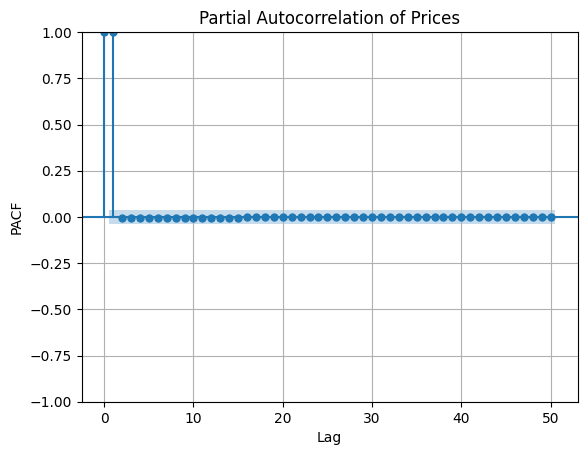

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12, 6))
plot_pacf(df_price_resampled['price'], lags=50)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation of Prices')
plt.grid(True)
plt.show()

### Correlation

In [9]:
# Make counts have common idx
common_index = df_count_resampled.index.intersection(df_price_resampled.index)

# Reindex datasets with common idx
df_count_resampled_aligned = df_count_resampled.reindex(common_index)
df_price_resampled_aligned = df_price_resampled.reindex(common_index)

correlation = df_price_resampled.corrwith(df_count_resampled)
df = pd.DataFrame({'prices': df_count_resampled_aligned['count'], 'B': df_price_resampled_aligned['price']})
correlation = df.corr()
print(correlation)

          prices         B
prices  1.000000 -0.802664
B      -0.802664  1.000000


## Linear Regression

Mean Squared Error: 0.0002507262479479043
Root Mean Squared Error: 0.01583433762264479
R-squared: 0.6490448452299573
Coefficients: [-6.85751065e-09]
Intercept: 0.10081829682296949


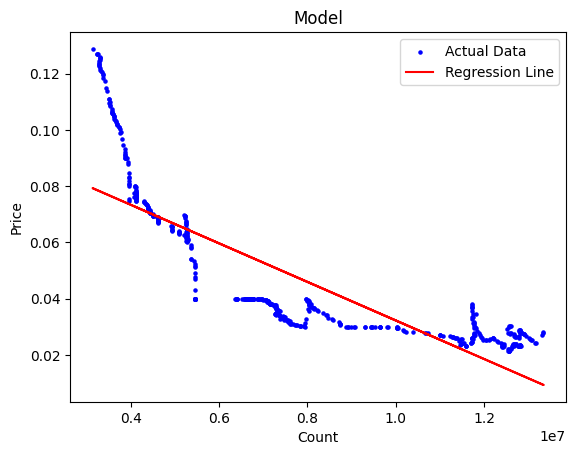

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split into training and testing
x =  df_count_resampled_aligned['count'].to_numpy().reshape(-1, 1)
y = df_price_resampled_aligned['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=5)
plt.plot(X_test, y_pred, color='red', label='Regression Line')

plt.xlabel('Count')
plt.ylabel('Price')
plt.title('Model')
plt.legend()

plt.show()

## ARIMA

In [11]:
from statsmodels.tsa.arima.model import ARIMA

In [64]:
x = df_count_resampled_aligned['count'].to_numpy().reshape(-1, 1)
y = df_price_resampled_aligned['price']

train_size = int(len(y) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

for d in range(20):
    model = ARIMA(y_train, exog=x_train, order=(0, d, 2))
    print("d value: " + str(d))
    results = model.fit()
    y_pred = results.forecast(steps=len(y_test), exog=x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)

d value: 0


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
d value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 1.7582689777458667e-05
Root Mean Squared Error: 0.0041931718039520715
R-squared: -0.213449181953687
d value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0015816796403963712
Root Mean Squared Error: 0.03977033618661491
R-squared: -108.15780748246728
d value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.03335588323569565
Root Mean Squared Error: 0.18263593084520816
R-squared: -2301.0180494561273
d value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.7295132644495697
Root Mean Squared Error: 0.8541154865997745
R-squared: -50345.521787899124
d value: 5


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 7.518099130514178e+16
Root Mean Squared Error: 274191523.03662086
R-squared: -5.188529943504317e+21
d value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 412802555322.50604
Root Mean Squared Error: 642497.1247581627
R-squared: -2.848909520696138e+16
d value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 1.3083468484334524e+32
Root Mean Squared Error: 1.1438299036279182e+16
R-squared: -9.029405813543987e+36
d value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 7.590372097137838e+34
Root Mean Squared Error: 2.7550629933157315e+17
R-squared: -5.238408303036815e+39
d value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 4.991776944486432e+22
Root Mean Squared Error: 223422848976.6978
R-squared: -3.4450176431753153e+27
d value: 10


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 2.576555346446598e+48
Root Mean Squared Error: 1.6051652084588047e+24
R-squared: -1.7781801402264849e+53
d value: 11


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 3.739036694069549e+54
Root Mean Squared Error: 1.9336588877228447e+27
R-squared: -2.5804533180868596e+59
d value: 12


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 1.055781255327266e+61
Root Mean Squared Error: 3.2492787743240285e+30
R-squared: -7.286353321443166e+65
d value: 13


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 2.0066367346372363e+63
Root Mean Squared Error: 4.479549904440441e+31
R-squared: -1.3848573426151358e+68
d value: 14


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 4.040932531491653e+43
Root Mean Squared Error: 6.356832962640794e+21
R-squared: -2.7888032699950847e+48
d value: 15


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 1.3977677423472544e+77
Root Mean Squared Error: 3.738673216994572e+38
R-squared: -9.646533863590002e+81
d value: 16


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 2.791258062209091e+81
Root Mean Squared Error: 5.283235809813046e+40
R-squared: -1.9263547586169187e+86
d value: 17


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 1.8695896154243135e+86
Root Mean Squared Error: 1.367329373422627e+43
R-squared: -1.2902758441056017e+91
d value: 18


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 8.807367336705984e+91
Root Mean Squared Error: 9.38475750177168e+45
R-squared: -6.078303618592421e+96
d value: 19


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 1.6213819387967078e+90
Root Mean Squared Error: 1.2733349672402419e+45
R-squared: -1.1189781610033717e+95


In [39]:
x = df_count_resampled_aligned['count'].to_numpy().reshape(-1, 1)
y = df_price_resampled_aligned['price']

train_size = int(len(y) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

for p in range(10):
    for q in range(10):
        model = ARIMA(y_train, exog=x_train, order=(p, 0, q))
        print("p value: " + str(p) + " q value: " + str(q))
        results = model.fit()
        y_pred = results.forecast(steps=len(y_test), exog=x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        print("Mean Squared Error:", mse)
        print("Root Mean Squared Error:", rmse)
        print("R-squared:", r2)

p value: 0 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 0 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 1 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003195566885228919
Root Mean Squared Error: 0.017876148593108415
R-squared: -21.053838586918324
p value: 1 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003316519547302995
Root Mean Squared Error: 0.018211313921029957
R-squared: -21.888579520794494
p value: 1 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003423586111303283
Root Mean Squared Error: 0.018502935203105704
R-squared: -22.627487140419912
p value: 1 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00035598047200879955
Root Mean Squared Error: 0.018867444766284585
R-squared: -23.567584255757687
p value: 1 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003617649735266894
Root Mean Squared Error: 0.019020120229028246
R-squared: -23.966794997898635
p value: 1 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00036806611829544403
Root Mean Squared Error: 0.019185049343054712
R-squared: -24.401661281828613
p value: 1 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.000374004294257273
Root Mean Squared Error: 0.019339190630873696
R-squared: -24.811477689578478
p value: 1 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003836265283043757
Root Mean Squared Error: 0.019586386300294797
R-squared: -25.475545143466714
p value: 1 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00039246288750216534
Root Mean Squared Error: 0.019810676099067528
R-squared: -26.085376345388575
p value: 1 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00039649325512887326
Root Mean Squared Error: 0.019912138386644296
R-squared: -26.36352754759378
p value: 2 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00033747310737916944
Root Mean Squared Error: 0.01837044113186097
R-squared: -22.29031969873101
p value: 2 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00037750576677587363
Root Mean Squared Error: 0.019429507630814365
R-squared: -25.053127802109973
p value: 2 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean Squared Error: 0.0013085714177033772
Root Mean Squared Error: 0.03617418164524772
R-squared: -89.30955652620553
p value: 2 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0015568888385222093
Root Mean Squared Error: 0.03945743071364644
R-squared: -106.44689870599875
p value: 2 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00024053992716749248
Root Mean Squared Error: 0.015509349669392733
R-squared: -15.600587369902446
p value: 2 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00047838800156635046
Root Mean Squared Error: 0.021872082698416045
R-squared: -32.01539960634227
p value: 2 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00048237645561888
Root Mean Squared Error: 0.021963070268495706
R-squared: -32.29065819126632
p value: 2 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004739951899602881
Root Mean Squared Error: 0.021771430590576454
R-squared: -31.712234748330232
p value: 2 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005008202281086426
Root Mean Squared Error: 0.02237901311739735
R-squared: -33.56353400964848
p value: 2 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.000575994162087435
Root Mean Squared Error: 0.02399987837651339
R-squared: -38.7515768998638
p value: 3 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003500982579309977
Root Mean Squared Error: 0.018710912803254622
R-squared: -23.16162999329121
p value: 3 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003466885109575974
Root Mean Squared Error: 0.018619573329096386
R-squared: -22.926310214127156
p value: 3 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004721272449840125
Root Mean Squared Error: 0.021728489247621715
R-squared: -31.583320666805456
p value: 3 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0009566161906306961
Root Mean Squared Error: 0.030929212576958635
R-squared: -65.01976993603357
p value: 3 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003681681473112517
Root Mean Squared Error: 0.019187708234993873
R-squared: -24.408702697410316
p value: 3 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004947734917003197
Root Mean Squared Error: 0.022243504483338943
R-squared: -33.146225427114324
p value: 3 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004905517658015891
Root Mean Squared Error: 0.022148403233677796
R-squared: -32.854867853097694
p value: 3 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004799399595124665
Root Mean Squared Error: 0.0219075320269643
R-squared: -32.122506205160576
p value: 3 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004992064052330717
Root Mean Squared Error: 0.022342927409654083
R-squared: -33.45215787363258
p value: 3 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005631185448590323
Root Mean Squared Error: 0.02373011893899886
R-squared: -37.862980934701284
p value: 4 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00036487807896937055
Root Mean Squared Error: 0.019101782088835863
R-squared: -24.181642401826558
p value: 4 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003565875923316926
Root Mean Squared Error: 0.01888352700984889
R-squared: -23.609483968969172
p value: 4 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.000572387808869842
Root Mean Squared Error: 0.023924627664184076
R-squared: -38.502688566104176
p value: 4 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0006485534208553242
Root Mean Squared Error: 0.02546671201500744
R-squared: -43.75917097730348
p value: 4 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.00047506475974222305
Root Mean Squared Error: 0.021795980357447176
R-squared: -31.786049880904272
p value: 4 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 4 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005020474313926009
Root Mean Squared Error: 0.022406414960733922
R-squared: -33.64822803768731
p value: 4 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004884486844408139
Root Mean Squared Error: 0.02210087519626347
R-squared: -32.70972610350678
p value: 4 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004992959592970568
Root Mean Squared Error: 0.022344931400589636
R-squared: -33.45833834471287
p value: 4 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005419985535976501
Root Mean Squared Error: 0.02328086238947454
R-squared: -36.40540894524101
p value: 5 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003822523313879406
Root Mean Squared Error: 0.01955127441851146
R-squared: -25.380706518364583
p value: 5 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003678105634364888
Root Mean Squared Error: 0.019178387925904743
R-squared: -24.384024456151288
p value: 5 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005963161500229091
Root Mean Squared Error: 0.02441958537778455
R-squared: -40.15407560444699
p value: 5 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0011528425344533185
Root Mean Squared Error: 0.033953534933101125
R-squared: -78.56210614301064
p value: 5 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.0004919831157554569
Root Mean Squared Error: 0.022180692409288237
R-squared: -32.953650829570215
p value: 5 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 5 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005032207772398674
Root Mean Squared Error: 0.02243258293732283
R-squared: -33.7292051564635
p value: 5 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004981857115456381
Root Mean Squared Error: 0.02232007418324675
R-squared: -33.38171586869944
p value: 5 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004991658190422051
Root Mean Squared Error: 0.022342019135302097
R-squared: -33.449356864189255
p value: 5 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005246646313852325
Root Mean Squared Error: 0.022905558962514592
R-squared: -35.20912817165467
p value: 6 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00040200241196626984
Root Mean Squared Error: 0.020049997804645014
R-squared: -26.743735692206776
p value: 6 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003801527931204271
Root Mean Squared Error: 0.01949750735659374
R-squared: -25.235809291294075
p value: 6 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0003879010971783981
Root Mean Squared Error: 0.019695204928570763
R-squared: -25.770549614855213
p value: 6 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012935280514819324
Root Mean Squared Error: 0.03596565099483023
R-squared: -88.27135584893233
p value: 6 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error: 0.000498993106982265
Root Mean Squared Error: 0.022338153616229456
R-squared: -33.43743733933268
p value: 6 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 6 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005093259399806834
Root Mean Squared Error: 0.02256825070714794
R-squared: -34.15054596536721
p value: 6 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005006677468548636
Root Mean Squared Error: 0.022375606066760822
R-squared: -33.55301069069085
p value: 6 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005012856455641789
Root Mean Squared Error: 0.02238940922767233
R-squared: -33.59565426188722
p value: 6 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005142094184095845
Root Mean Squared Error: 0.022676186152207883
R-squared: -34.48757363176189
p value: 7 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00043708575900016744
Root Mean Squared Error: 0.02090659606440435
R-squared: -29.164972675700522
p value: 7 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004020737529400457
Root Mean Squared Error: 0.020051776802569036
R-squared: -26.74865920774187
p value: 7 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004084695210120042
Root Mean Squared Error: 0.020210628911837558
R-squared: -27.190055810486534
p value: 7 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005711746773307882
Root Mean Squared Error: 0.02389926102060037
R-squared: -38.41896568341108
p value: 7 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004915863028853606
Root Mean Squared Error: 0.02217174559851706
R-squared: -32.92626524416199
p value: 7 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 7 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.000505306223183167
Root Mean Squared Error: 0.022479017398079636
R-squared: -33.87312981793082
p value: 7 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004998207460039087
Root Mean Squared Error: 0.022356671174481875
R-squared: -33.49455589778294
p value: 7 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005013897565842923
Root Mean Squared Error: 0.022391734112933107
R-squared: -33.60283936460972
p value: 7 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005096348154761019
Root Mean Squared Error: 0.022575092812125976
R-squared: -34.171862653654664
p value: 8 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00045720707820471804
Root Mean Squared Error: 0.021382401132817568
R-squared: -30.553622457822765
p value: 8 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004135026048028272
Root Mean Squared Error: 0.02033476345578741
R-squared: -27.537408319458642
p value: 8 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004193671676368853
Root Mean Squared Error: 0.020478456182947125
R-squared: -27.94214440156976
p value: 8 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00047034146677619017
Root Mean Squared Error: 0.021687357302728014
R-squared: -31.460077230627057
p value: 8 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004760746764624128
Root Mean Squared Error: 0.021819135557175788
R-squared: -31.85574812579548
p value: 8 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 8 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004985262821711943
Root Mean Squared Error: 0.022327702124741684
R-squared: -33.40521996006482
p value: 8 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005002558685735411
Root Mean Squared Error: 0.022366400438459944
R-squared: -33.524585383194605
p value: 8 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005047287233089894
Root Mean Squared Error: 0.0224661684162874
R-squared: -33.83327432603688
p value: 8 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005061502348717345
Root Mean Squared Error: 0.02249778288791441
R-squared: -33.93137831722269
p value: 9 q value: 0


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004587511909318964
Root Mean Squared Error: 0.021418477792128375
R-squared: -30.66018762784817
p value: 9 q value: 1


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004135290856009522
Root Mean Squared Error: 0.020335414566734364
R-squared: -27.53923586138931
p value: 9 q value: 2


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00041955869155285133
Root Mean Squared Error: 0.02048313187852022
R-squared: -27.955362205108074
p value: 9 q value: 3


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004354890205127989
Root Mean Squared Error: 0.020868373691133646
R-squared: -29.05477559915451
p value: 9 q value: 4


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.00046380396647215436
Root Mean Squared Error: 0.021536108433794495
R-squared: -31.00889914033712
p value: 9 q value: 5


/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0012666944574315304
Root Mean Squared Error: 0.035590651264503864
R-squared: -86.41946611184095
p value: 9 q value: 6


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0004937642829810843
Root Mean Squared Error: 0.022220807433148873
R-squared: -33.07657604409747
p value: 9 q value: 7


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005050773798538843
Root Mean Squared Error: 0.0224739266674492
R-squared: -33.85733645785746
p value: 9 q value: 8


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005057549368875526
Root Mean Squared Error: 0.022488995906610697
R-squared: -33.90409727992951
p value: 9 q value: 9


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.0005121214551637869
Root Mean Squared Error: 0.022630100644137376
R-squared: -34.34347524154798


In [50]:
x = df_count_resampled_aligned['count'].to_numpy().reshape(-1, 1)
y = df_price_resampled_aligned['price']

train_size = int(len(y) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

for p in range(10):
    for q in range(10):
        model = ARIMA(y_train, order=(p, 1, q))
        results = model.fit()
        y_pred = results.forecast(steps=len(y_test))
        if (r2_score(y_test, y_pred) > r2):
            best_p = p
            best_q = q
            y_pred = results.forecast(steps=len(y_test))
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

print("Printing best values: ")
print("p value: " + str(best_p) + " q value: " + str(best_q))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)      

/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: C

/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-station

/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likeliho

Printing best values: 
p value: 2 q value: 6
Mean Squared Error: 1.2218209545425335e-05
Root Mean Squared Error: 0.003495455556207994
R-squared: 0.15677427256650256


In [51]:
x = df_count_resampled_aligned['count'].to_numpy().reshape(-1, 1)
y = df_price_resampled_aligned['price']

train_size = int(len(y) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

for p in range(10):
    for q in range(10):
        model = ARIMA(y_train, order=(p, 2, q))
        results = model.fit()
        y_pred = results.forecast(steps=len(y_test))
        if (r2_score(y_test, y_pred) > r2):
            best_p = p
            best_q = q
            y_pred = results.forecast(steps=len(y_test))
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

print("Printing best values: ")
print("p value: " + str(best_p) + " q value: " + str(best_q))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)      

/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likeliho

/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-station

/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

Printing best values: 
p value: 2 q value: 6
Mean Squared Error: 1.2218209545425335e-05
Root Mean Squared Error: 0.003495455556207994
R-squared: 0.15677427256650256


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


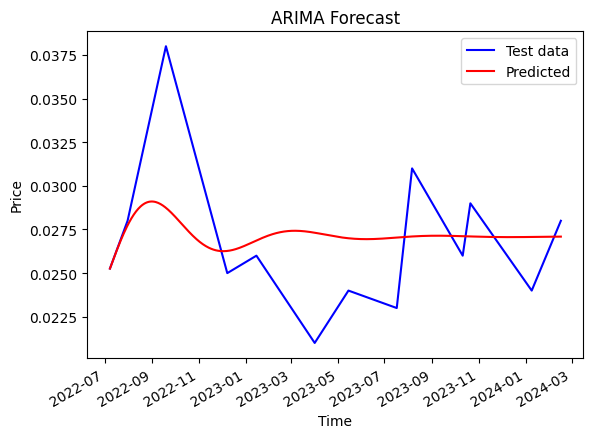

In [63]:
x = df_count_resampled_aligned['count'].to_numpy().reshape(-1, 1)
y = df_price_resampled_aligned['price']

train_size = int(len(y) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = ARIMA(y_train, order=(2, 1, 6))
results = model.fit()
y_pred = results.forecast(steps=len(y_test))

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(y_test.index, y_test.values, color='blue', label='Test data')
ax.plot(y_test.index, y_pred, color='red', label='Predicted')

plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Price')

plt.legend()
plt.show()  